# Problem Statement
Look to  provide a model to find undervalued properties for investment/flipping and assess what factors drive price
 - How well do we predict typical prices?
 - What features dictate the price the most?


In [1]:
#Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import itertools


from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# EDA and Cleaning
Load in and take a precursory look at the data. Notice that some values have many missing entries, some not as much. A few notes for what was found:
 - One garage was built in the future
 - Some variables will be correlated, and using intution on how to set will be good (if the pool quality is null and pool area is null, probably no pool so set to `'None'` and `0`
 

In [2]:
#I want my own colors
colors = cm.rainbow(np.linspace(0, 1, 6))

In [3]:
#load in training set
house = pd.read_csv('../datasets/train.csv')
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [4]:
#Initial information
house.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [5]:
#Count null values
for col in house.columns:
    if house[col].isnull().sum() > 0:
        print(col)

Lot Frontage
Alley
Mas Vnr Type
Mas Vnr Area
Bsmt Qual
Bsmt Cond
Bsmt Exposure
BsmtFin Type 1
BsmtFin SF 1
BsmtFin Type 2
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
Bsmt Full Bath
Bsmt Half Bath
Fireplace Qu
Garage Type
Garage Yr Blt
Garage Finish
Garage Cars
Garage Area
Garage Qual
Garage Cond
Pool QC
Fence
Misc Feature


# Emtpy Values
Treat values as:
 - N/A to 'None'
 - Some empties are because they aren't there, make 0
 - Some special cases

In [6]:
#Frontage by neighborhood average, if no info on neighborhood take total mean
house['Lot Frontage'].fillna(house.groupby('Neighborhood')['Lot Frontage'].transform('mean'))
house['Lot Frontage'].fillna(house['Lot Frontage'].mean(),inplace=True)

house['Alley'].fillna('None',inplace=True)
house['Mas Vnr Type'].fillna('None',inplace=True)
house['Mas Vnr Area'].fillna(0,inplace=True)
house['Bsmt Qual'].fillna('None',inplace=True)
house['Bsmt Cond'].fillna('None',inplace=True)
house['Bsmt Exposure'].fillna('None',inplace=True)
house['BsmtFin Type 1'].fillna('None',inplace=True)
house['BsmtFin SF 1'].fillna(0,inplace=True)
house['BsmtFin Type 2'].fillna('None',inplace=True)
house['BsmtFin SF 2'].fillna(0,inplace=True)
house['Bsmt Unf SF'].fillna(0,inplace=True)
house['Total Bsmt SF'].fillna(0,inplace=True)
house['Bsmt Full Bath'].fillna(0,inplace=True)
house['Bsmt Half Bath'].fillna(0,inplace=True)
house['Fireplace Qu'].fillna('None',inplace=True)
house['Garage Type'].fillna('None',inplace=True)

#May not have a garage, just dummy to mean
house['Garage Yr Blt'].fillna(house['Garage Yr Blt'].mean(),inplace=True)
house['Garage Finish'].fillna('None',inplace=True)
house['Garage Cars'].fillna(0,inplace=True)
house['Garage Area'].fillna(0,inplace=True)
house['Garage Qual'].fillna('None',inplace=True)
house['Garage Cond'].fillna('None',inplace=True)
house['Pool QC'].fillna('None',inplace=True)
house['Fence'].fillna('None',inplace=True)
house['Misc Feature'].fillna('None',inplace=True)


In [7]:
#One garage value is 200 years in the future, fix that
house['Garage Yr Blt'] = house['Garage Yr Blt'].map(lambda x: np.nan if x > 2020 else x)
house['Garage Yr Blt'].fillna(house[house['Garage Yr Blt'].isnull()]['Year Remod/Add'].mean(),inplace=True)

In [8]:
#recheck nulls, there are none
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [9]:
#Drop non descriptive ones for training set
house.drop(columns=['Id','PID'],inplace=True)

In [10]:
#funtion to convert quality to scale of 0-5
def convert_qual(qual):
    qual_list = ['None','Po','Fa','TA','Gd','Ex']
    return qual_list.index(qual)

In [11]:
#Apply converstion function
house['Exter Qual'] = house['Exter Qual'].map(convert_qual)
house['Exter Cond'] = house['Exter Cond'].map(convert_qual)
house['Bsmt Qual'] = house['Bsmt Qual'].map(convert_qual)
house['Bsmt Cond'] = house['Bsmt Cond'].map(convert_qual)
house['Kitchen Qual'] = house['Kitchen Qual'].map(convert_qual)
house['Fireplace Qu'] = house['Fireplace Qu'].map(convert_qual)
house['Garage Qual'] = house['Garage Qual'].map(convert_qual)
house['Garage Cond'] = house['Garage Cond'].map(convert_qual)
house['Pool QC'] = house['Pool QC'].map(convert_qual)

In [12]:
#change to more intuitive values

house['total_sf'] = house['1st Flr SF'] + house['2nd Flr SF'] + house['Total Bsmt SF']
house['baths'] = house['Full Bath'] + house['Half Bath'] + house['Bsmt Full Bath'] + house['Bsmt Half Bath']
house['has_porch'] = (house['Open Porch SF'] + house['Enclosed Porch'] 
                      + house['3Ssn Porch'] + house['Screen Porch'] > 0).astype(int)
house['porch_sf'] = house['Open Porch SF'] + house['Enclosed Porch'] + house['3Ssn Porch'] + house['Screen Porch']
house['sold_after_0601'] = 12*(house['Yr Sold'] - 2006) + house['Mo Sold']
house['blt_after_1900'] = house['Year Built'] - 1900
house['rem_after_1900'] = house['Year Remod/Add'] - 1900
house['has_basement'] = (house['Total Bsmt SF'] > 0).astype(int)



In [13]:
#convert categorical data to numerical, grouping by the mean for category
def nom_to_num(df,col_in):
    cat_list = list(df[col_in].unique())
    cat_mean = [[cat,house[house[col_in] == cat]['SalePrice'].mean()] for cat in cat_list]
    cat_mean = sorted(cat_mean,key=lambda x:x[1])
    cat_dict = {cat[0]:i for i,cat in enumerate(cat_mean)}
    return house[col_in].map(cat_dict),cat_dict

In [14]:
#all categorical columns converted to number

#dict list is to map test data later
dict_list = []
house['neigh_num'], temp_dict = nom_to_num(house,'Neighborhood')
dict_list.append(temp_dict)
house['ms_num'], temp_dict = nom_to_num(house,'MS SubClass')
dict_list.append(temp_dict)
house['zone_num'], temp_dict = nom_to_num(house,'MS Zoning')
dict_list.append(temp_dict)
house['lotshape_num'], temp_dict = nom_to_num(house,'Lot Shape')
dict_list.append(temp_dict)
house['landcont_num'], temp_dict = nom_to_num(house,'Land Contour')
dict_list.append(temp_dict)
house['util_num'], temp_dict = nom_to_num(house,'Utilities')
dict_list.append(temp_dict)
house['lotconf_num'], temp_dict = nom_to_num(house,'Lot Config')
dict_list.append(temp_dict)
house['slope_num'], temp_dict = nom_to_num(house,'Land Slope')
dict_list.append(temp_dict)
house['neigh_num'], temp_dict = nom_to_num(house,'Neighborhood')
dict_list.append(temp_dict)
house['cond1_num'], temp_dict = nom_to_num(house,'Condition 1')
dict_list.append(temp_dict)
house['cond2_num'], temp_dict = nom_to_num(house,'Condition 2')
dict_list.append(temp_dict)
house['bldgtyp_num'], temp_dict = nom_to_num(house,'Bldg Type')
dict_list.append(temp_dict)
house['houstyle_num'], temp_dict = nom_to_num(house,'House Style')
dict_list.append(temp_dict)
house['roofst_num'], temp_dict = nom_to_num(house,'Roof Style')
dict_list.append(temp_dict)
house['roofmat_num'], temp_dict = nom_to_num(house,'Roof Matl')
dict_list.append(temp_dict)
house['ext1_num'], temp_dict = nom_to_num(house,'Exterior 1st')
dict_list.append(temp_dict)
house['ext2_num'], temp_dict = nom_to_num(house,'Exterior 2nd')
dict_list.append(temp_dict)
house['masvnrtyp_num'], temp_dict = nom_to_num(house,'Mas Vnr Type')
dict_list.append(temp_dict)
house['found_num'], temp_dict = nom_to_num(house,'Foundation')
dict_list.append(temp_dict)
house['bsmtexp_num'], temp_dict = nom_to_num(house,'Bsmt Exposure')
dict_list.append(temp_dict)
house['bsmtexp_num'], temp_dict = nom_to_num(house,'Bsmt Exposure')
dict_list.append(temp_dict)
house['bsmtfin1_num'], temp_dict = nom_to_num(house,'BsmtFin Type 1')
dict_list.append(temp_dict)
house['bsmtfin2_num'], temp_dict = nom_to_num(house,'BsmtFin Type 2')
dict_list.append(temp_dict)
house['heat_num'], temp_dict = nom_to_num(house,'Heating')
dict_list.append(temp_dict)
house['elec_num'], temp_dict = nom_to_num(house,'Electrical')
dict_list.append(temp_dict)
house['gartyp_num'], temp_dict = nom_to_num(house,'Garage Type')
dict_list.append(temp_dict)
house['fence_num'], temp_dict = nom_to_num(house,'Fence')
dict_list.append(temp_dict)
house['garfin_num'], temp_dict = nom_to_num(house,'Garage Finish')
dict_list.append(temp_dict)
house['func_num'], temp_dict = nom_to_num(house,'Functional')
dict_list.append(temp_dict)
house['misc_num'], temp_dict = nom_to_num(house,'Misc Feature')
dict_list.append(temp_dict)
house['sale_num'], temp_dict = nom_to_num(house,'Sale Type')
dict_list.append(temp_dict)


In [15]:
#dummify categorical data that may be useful and only has 2 or 3 unique values
house = pd.get_dummies(house,columns=['Street'],drop_first=True)
house = pd.get_dummies(house,columns=['Central Air'],drop_first=True)
house = pd.get_dummies(house,columns=['Paved Drive'],drop_first=True)


# Variables I skip
Some variables I skip for now because they overlap a lot with variables I have created. I would like for the fit to be based somewhat reasonably, especcially when making interaction terms. They are still allowed to affect the fit if they are a predictor without interaction. 

In [16]:
#From EDA, thise were removed because of overlap with other variables and to limit code run time
cols_to_skip = ['35sn Porch','Pool Area','Pool QC','Enclosed Porch','Screen Porch','Fireplaces',
                'Fireplace Qu','Bsmt Full Bath','Bsmt Half Bath','Low Qual Fin SF',
                'BsmtFin SF 1','BsmtFin SF 2','1st Flr SF','2nd Flr SF','Full Bath','Half Bath',
                'Mo Sold','Yr Sold','Misc Val','Wood Deck SF','Gr Liv Area','Kitchen AbvGr',
                'Open Porch SF','SalePrice','MS SubClass','Year Built','util_num','slope_num',
                'roofmat_num']


In [17]:
#tracking numerical colums for fits
number_cols = [col for col in house.columns if house[col].dtypes != object]

# Exploratory visuals
Look at pair plots and heatmap for everything in relation to price. This will be revisted once interactions are made. Quality and a lot of area values tightly correlated

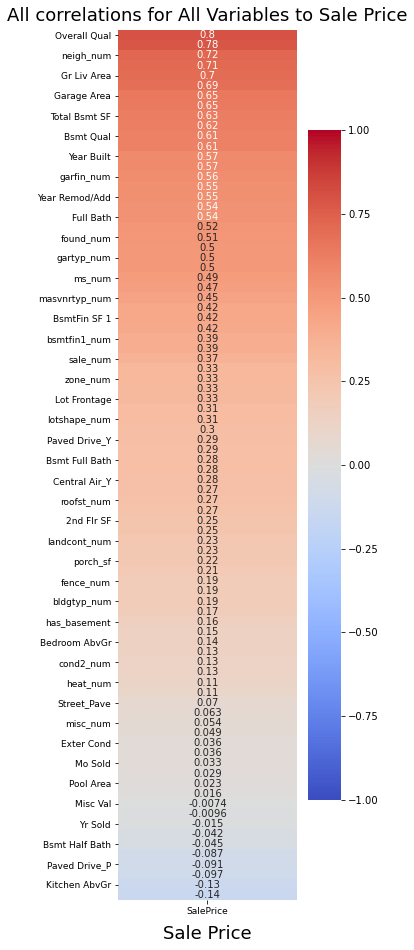

In [18]:
def one_corr_heatmap(data, target_variable, title, x_label, size_var = 18, use_abs = False):
    # set size_var as a parameter with a default of 18
    plt.figure(figsize=(4,16))
    # abstract title as parameter
    plt.title(title, fontsize = size_var, pad = size_var / 2)
    
    sns.heatmap(data.corr()[[target_variable]].sort_values(by=target_variable, 
                                                           ascending = False, 
                                                           key = np.abs if use_abs else None)[1:], 
                cmap='coolwarm', vmin = -1, vmax = 1, annot = True)
    
    # abstract the "x" axis lavel as a parameter, x_label
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2)

    # abstract the "y" axis lavel as a parameter, y_label
    plt.yticks(fontsize=size_var/2);

one_corr_heatmap(
    data = house,
    target_variable='SalePrice',
    title = 'All correlations for All Variables to Sale Price',
    x_label = 'Sale Price'
)

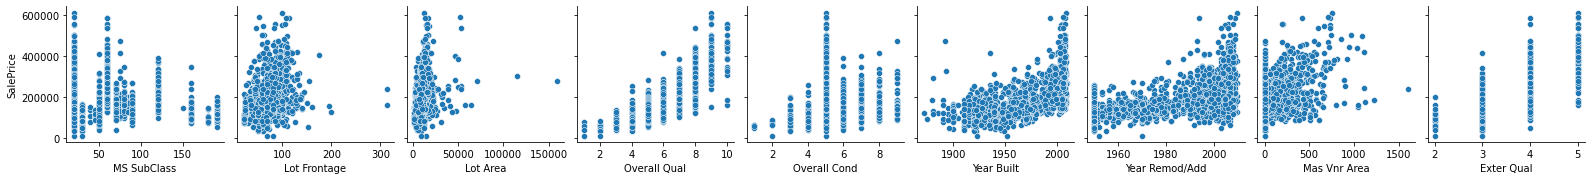

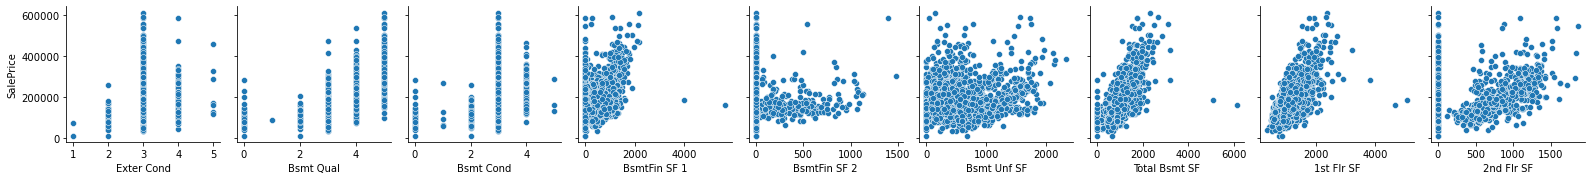

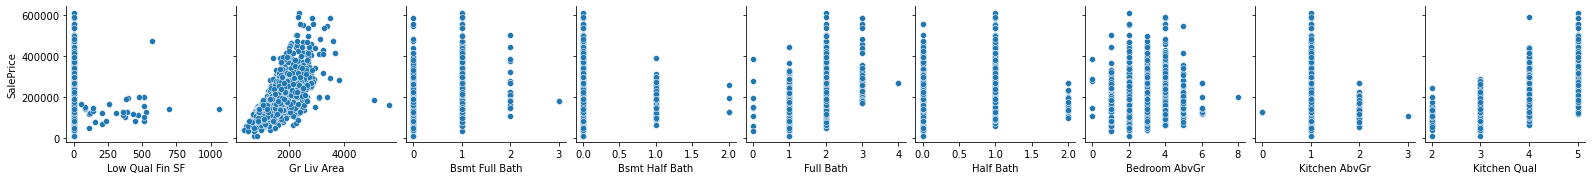

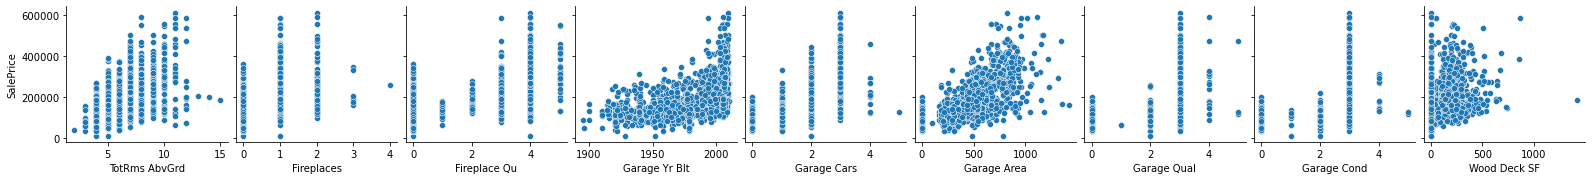

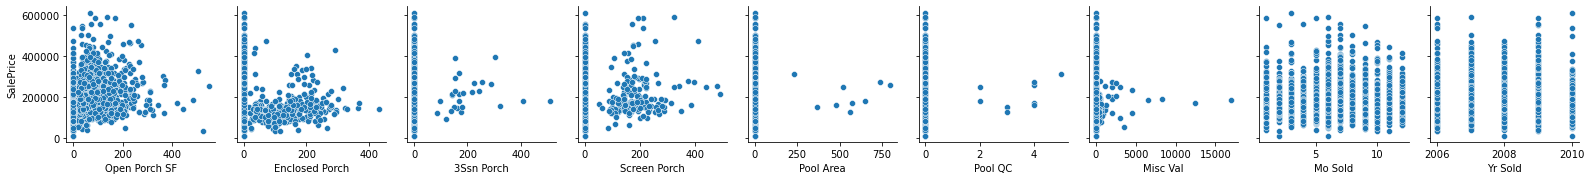

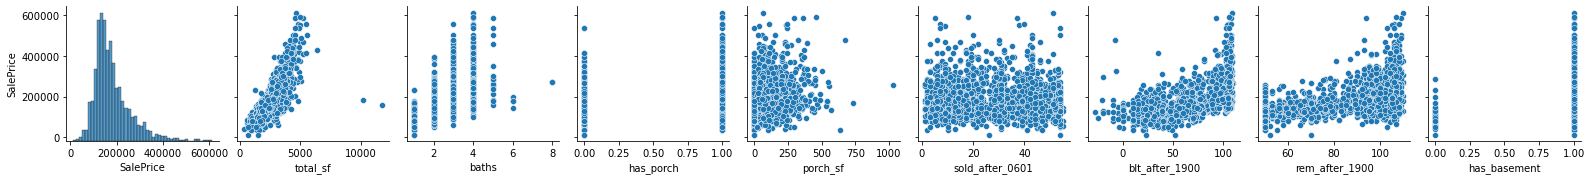

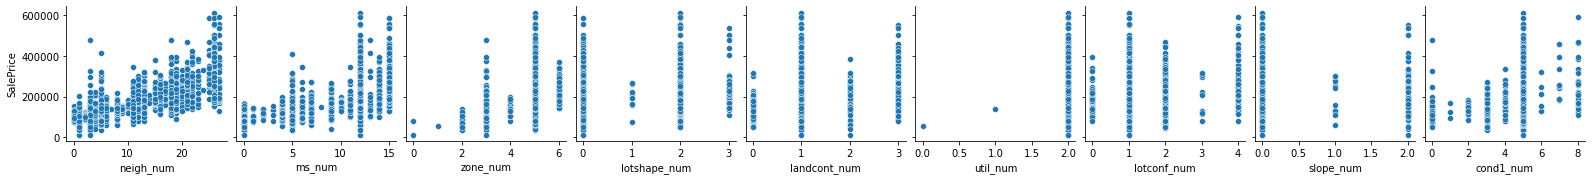

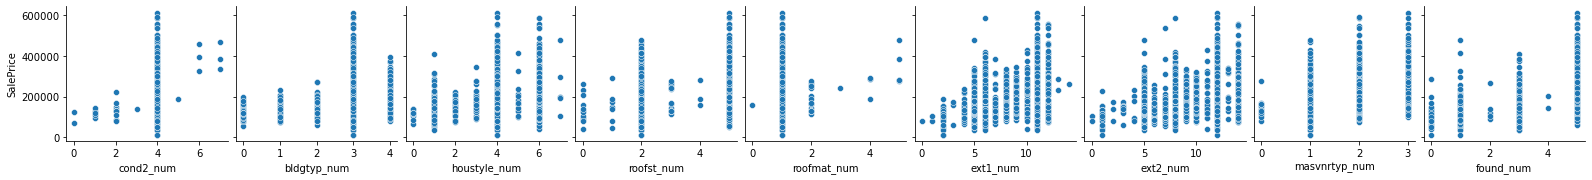

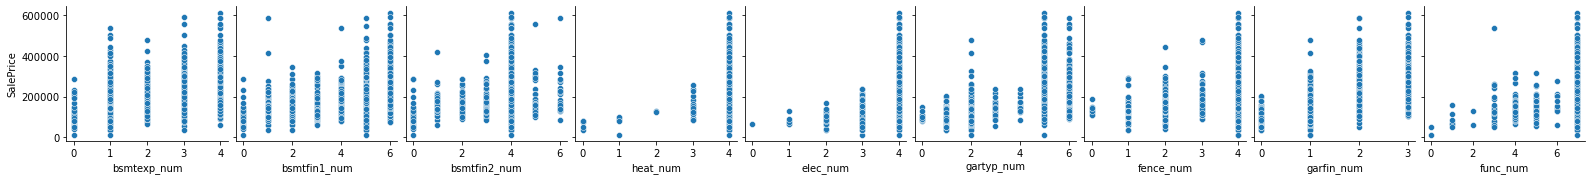

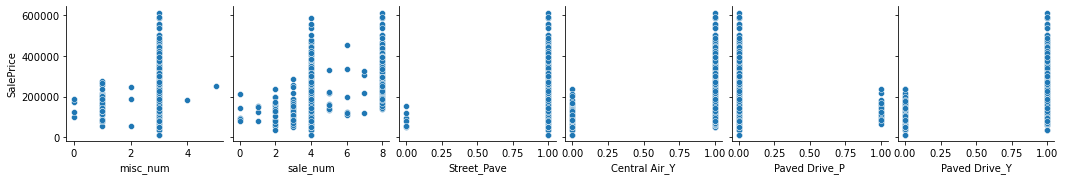

In [19]:
#pair plot to examine base values
for i in range(10):
     sns.pairplot(house,y_vars=['SalePrice'],x_vars=number_cols[i*9:9+i*9])

In [20]:
#add interaction terms, skip cols to skip
house_high = house[number_cols]
for i in range(len(number_cols)):
    col = number_cols[i]
    if col in cols_to_skip:
        pass
    else:
        for j in range(i,len(number_cols)):
            col2 = number_cols[j]
            if col2 in cols_to_skip:
                pass
            else:
                house_high[col+'*'+col2] = house[col]*house[col2]
house_high['SalePrice'] = house['SalePrice']
house_high.shape

<ipython-input-20-f12c490f1103>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_high[col+'*'+col2] = house[col]*house[col2]


(2051, 1857)

In [21]:
#new number cols with interactions
bignumber_cols = [col for col in house_high.columns if house_high[col].dtypes != object]

In [22]:
#Pair plot for all variables, with interaction terms included. 232 was the range for latest set

# for i in range(len(bignumber_cols)//8 + 1):
#      sns.pairplot(house_high,y_vars=['SalePrice'],x_vars=bignumber_cols[i*8:8+i*8])

# Model Iteration
The fit is performed by finding the best single fit paramater and saving it. It then finds the best second parameter used in tandem with the first. This is repeated `n_iter` times. train_size at 85% and the scoring is `cv=5` for a `cross_val_score`

Block of commented code is the iteration, blocked to help with any desire to run the code yourself without waiting half an hour. 

In [23]:
#Instantiate Model
lr = LinearRegression()

In [24]:
# %%time
# n_iter = 40
# cat_list = []
# max_score, max_std = 9e99, 0
# print(max_score)
# for i in range(n_iter):
#     for subset in itertools.combinations(list(house_high.drop(columns=cat_list + ['total_sf*neigh_num','SalePrice'])), 1):
#         X = house_high[list(subset)+cat_list]
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)
#         score = cross_val_score(lr, X, y, cv=5,scoring='neg_mean_squared_error')
#         if max_score > -1*score.mean():
#             cats, max_score, max_std = subset, -1*score.mean(),score.std()
#     cat_list += list(cats)
#     print(cats,max_score)
# cat_list, max_score, max_std


# Ridge CV and Lasso CV
Run my variables though both ridge and lasso CV to see what comes out. Alpha list was changed as needed to have the best value encompassed. Both did not perform as well as my `LinearRegression` iterations, so the final product used was the LR result. This also makes interpretation easier, and makes variance more reasonable since it is grounded in the number of variables used. 

In [25]:
#Set up Standard scaler for RidgeCV and LassoCV
X = house_high.drop(columns='SalePrice')
y = house_high['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# Ridge CV

In [26]:
%%time
#Perform Ridge CV, original alphas 10^-2 to 10^-1 were too small
r_alphas = np.logspace(1,3,100)

ridge_cv = RidgeCV(alphas=r_alphas,scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)

Wall time: 43.4 s


RidgeCV(alphas=array([  10.        ,   10.47615753,   10.97498765,   11.49756995,
         12.0450354 ,   12.61856883,   13.21941148,   13.84886371,
         14.50828778,   15.19911083,   15.92282793,   16.68100537,
         17.475284  ,   18.3073828 ,   19.17910262,   20.09233003,
         21.04904145,   22.0513074 ,   23.101297  ,   24.20128265,
         25.35364494,   26.56087783,   27.82559402,   29.15053063,
         30.53855509,   31.99267138,   33.51602651,   35.11191734,
         36.7837...
        284.80358684,  298.36472403,  312.57158497,  327.45491629,
        343.04692863,  359.38136638,  376.49358068,  394.42060594,
        413.20124001,  432.87612811,  453.48785081,  475.08101621,
        497.70235643,  521.4008288 ,  546.22772177,  572.23676594,
        599.48425032,  628.02914418,  657.93322466,  689.26121043,
        722.08090184,  756.46332755,  792.48289835,  830.21756813,
        869.74900262,  911.16275612,  954.54845666, 1000.        ]),
        cv=5, scoring='r2

In [27]:
#Print the results
print('Training Ridge Score',ridge_cv.score(Z_train, y_train))
print('Test Ridge Score',ridge_cv.score(Z_test, y_test))

Training Ridge Score 0.956404350814212
Test Ridge Score 0.9174133057124856


In [28]:
#Check my alpha
ridge_cv.alpha_

135.30477745798075

# Lasso CV
Had to tweak values in order to get the series to reasonably converge. 

In [29]:
%%time
#Same things for the lasso_cv

l_alphas = np.logspace(1, 3, 100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=10000, tol=1e-2,n_jobs = -2)

lasso_cv.fit(Z_train, y_train);

Wall time: 5.33 s


LassoCV(alphas=array([  10.        ,   10.47615753,   10.97498765,   11.49756995,
         12.0450354 ,   12.61856883,   13.21941148,   13.84886371,
         14.50828778,   15.19911083,   15.92282793,   16.68100537,
         17.475284  ,   18.3073828 ,   19.17910262,   20.09233003,
         21.04904145,   22.0513074 ,   23.101297  ,   24.20128265,
         25.35364494,   26.56087783,   27.82559402,   29.15053063,
         30.53855509,   31.99267138,   33.51602651,   35.11191734,
         36.7837...
        284.80358684,  298.36472403,  312.57158497,  327.45491629,
        343.04692863,  359.38136638,  376.49358068,  394.42060594,
        413.20124001,  432.87612811,  453.48785081,  475.08101621,
        497.70235643,  521.4008288 ,  546.22772177,  572.23676594,
        599.48425032,  628.02914418,  657.93322466,  689.26121043,
        722.08090184,  756.46332755,  792.48289835,  830.21756813,
        869.74900262,  911.16275612,  954.54845666, 1000.        ]),
        cv=5, max_iter=10

In [30]:
#Score the result
preds = lasso_cv.predict(Z_test)
lasso_cv.score(Z_test,y_test), metrics.mean_squared_error(y_test,preds,squared=False),

(0.9247358479850638, 22378.891708646544)

In [31]:
Z_test.shape, y_test.shape,Z_train.shape, y_train.shape

((308, 1856), (308,), (1743, 1856), (1743,))

In [32]:
#check my lasso optimal alpha
lasso_cv.alpha_

148.4968262254465

In [33]:
#Check the variables it likes and count them
count = 0
lasso_res = []
for col, coef in zip(list(X_test.columns),list(lasso_cv.coef_)):
    if coef != 0:
        print(col, coef)
        lasso_res.append([col, coef])
        count += 1
print(count)

MS SubClass -480.72039850989916
Overall Qual -13803.630824181739
Exter Qual -2013.9615649642485
BsmtFin SF 2 -734.6469698319314
Total Bsmt SF -1104.3557465214378
2nd Flr SF 1960.347393217128
Low Qual Fin SF 728.1501981665433
Bsmt Half Bath -1551.0166608413942
Kitchen AbvGr -2120.2422644589337
Kitchen Qual -3023.738175683268
Fireplaces 2661.192085126275
Fireplace Qu 757.1064320681816
Wood Deck SF 429.03788599321473
Open Porch SF -1067.721766030408
Screen Porch 1820.0066651260568
Pool Area -995.9233772689951
Pool QC 1828.8417032014909
Misc Val -3235.2332086768038
blt_after_1900 1943.6004577981726
zone_num 1256.6638063241535
util_num 2.0977061748249426
slope_num 171.5078319452097
roofmat_num -156.08133822001744
found_num 309.6836823064738
Lot Frontage*Lot Area -7052.008086275608
Lot Frontage*Total Bsmt SF -2309.962123741042
Lot Frontage*Garage Cars 552.4409128420914
Lot Frontage*ms_num 25.120159916661475
Lot Frontage*landcont_num 1275.1377793277504
Lot Frontage*lotconf_num -2262.023123271

# Final Fit
Here the final values for the loop over the 40 variables is hard coded as to not be overwritten, and not have to rerun the fitting loop. Entries are ordered by when the algorithm added them to the list, so `'total_sf*neigh_num'` was the most powerful lone variable. Each after is what was best to be paired with preceding variables

In [34]:
#fit categories
cat_mse = ['total_sf*neigh_num','Overall Qual*Kitchen Qual','neigh_num*neigh_num','Bsmt Unf SF*blt_after_1900',
  'Garage Cars*sale_num','Overall Cond*total_sf','Total Bsmt SF*total_sf','Overall Cond*neigh_num',
  'blt_after_1900*bsmtexp_num','Lot Area*ext1_num','Overall Qual*Exter Qual','blt_after_1900*cond1_num',
  'landcont_num*roofst_num','Garage Area*porch_sf','MS SubClass','Fireplace Qu',
  'has_porch*neigh_num','has_basement*neigh_num','Bsmt Qual*zone_num','total_sf*bsmtfin2_num',
  'Lot Area*Lot Area','neigh_num*sale_num','sale_num*sale_num','has_porch*rem_after_1900',
  'houstyle_num*ext2_num','heat_num*func_num','porch_sf*misc_num','Screen Porch',
  'Bsmt Qual*Garage Cars','Lot Frontage*Paved Drive_Y','Bsmt Unf SF*porch_sf','Bsmt Qual*bsmtfin2_num',
  'total_sf*zone_num','baths*rem_after_1900','Bedroom AbvGr*neigh_num','Bedroom AbvGr*zone_num',
  'Overall Qual*total_sf','Overall Qual','Year Remod/Add*Kitchen Qual','Fireplaces']
#set vars
X = house_high[cat_mse]
y = house_high['SalePrice']
#train test split on preferred set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)
#fit
lr.fit(X_train,y_train)
#results
preds = lr.predict(X_test)
lr.score(X_train,y_train),lr.score(X_test,y_test),metrics.mean_squared_error(y_test,preds,squared=False)

(0.9364317864800413, 0.938028691461653, 20306.721915254446)

# Plots
Here are some of the interesting plots, most also included in the presentation. Alpha set to 0.3, as the overlap for a lot of the points can be misleading. 

Text(0, 0.5, 'SalePrice')

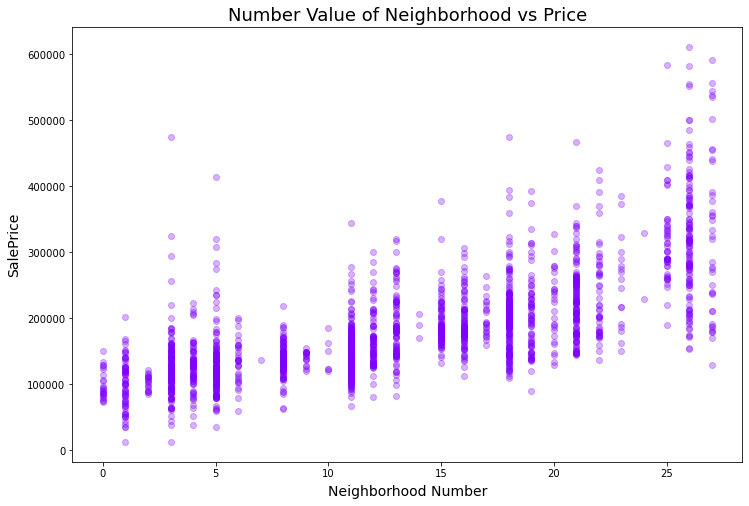

In [35]:
#Result of Numberfying the neighborhood, fairly linear, with only a couple odd categories

fig = plt.figure(figsize=(12,8))
plt.scatter(house['neigh_num'],house['SalePrice'],alpha = 0.3,color=colors[0])
plt.title('Number Value of Neighborhood vs Price',fontsize = 18)
plt.xlabel('Neighborhood Number', fontsize = 14, labelpad = 6)
plt.ylabel('SalePrice', fontsize = 14, labelpad = 6)


Text(0, 0.5, 'SalePrice')

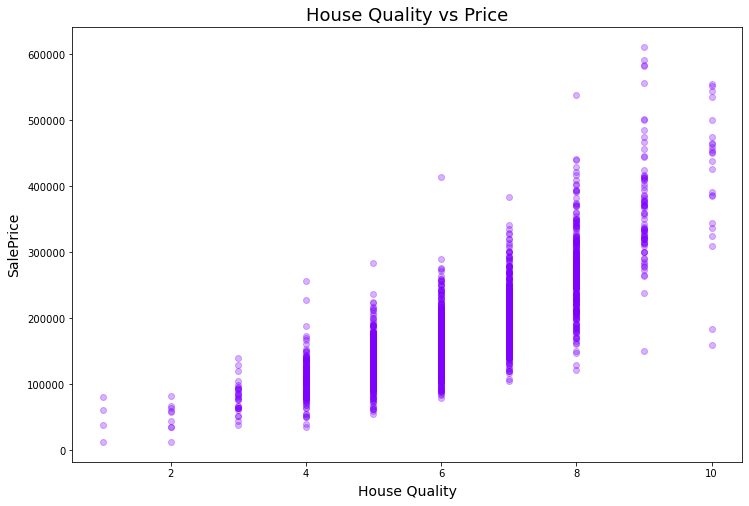

In [36]:
#House quality relation
fig = plt.figure(figsize=(12,8))
plt.scatter(house['Overall Qual'],house['SalePrice'],alpha = 0.3,color=colors[0])
plt.title('House Quality vs Price',fontsize = 18)
plt.xlabel('House Quality', fontsize = 14, labelpad = 6)
plt.ylabel('SalePrice', fontsize = 14, labelpad = 6)


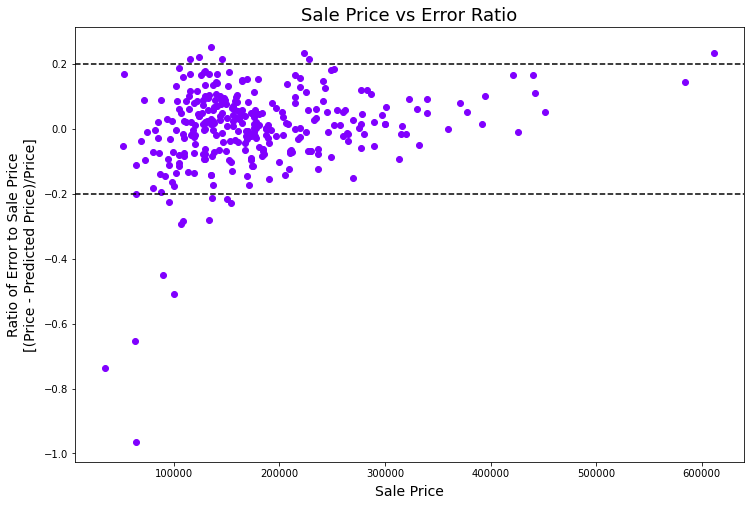

In [37]:
#Make sure for whatever iteration I have the right results, so just rerun the fit

cat_mse = ['total_sf*neigh_num','Overall Qual*Kitchen Qual','neigh_num*neigh_num','Bsmt Unf SF*blt_after_1900',
  'Garage Cars*sale_num','Overall Cond*total_sf','Total Bsmt SF*total_sf','Overall Cond*neigh_num',
  'blt_after_1900*bsmtexp_num','Lot Area*ext1_num','Overall Qual*Exter Qual','blt_after_1900*cond1_num',
  'landcont_num*roofst_num','Garage Area*porch_sf','MS SubClass','Fireplace Qu',
  'has_porch*neigh_num','has_basement*neigh_num','Bsmt Qual*zone_num','total_sf*bsmtfin2_num',
  'Lot Area*Lot Area','neigh_num*sale_num','sale_num*sale_num','has_porch*rem_after_1900',
  'houstyle_num*ext2_num','heat_num*func_num','porch_sf*misc_num','Screen Porch',
  'Bsmt Qual*Garage Cars','Lot Frontage*Paved Drive_Y','Bsmt Unf SF*porch_sf','Bsmt Qual*bsmtfin2_num',
  'total_sf*zone_num','baths*rem_after_1900','Bedroom AbvGr*neigh_num','Bedroom AbvGr*zone_num',
  'Overall Qual*total_sf','Overall Qual','Year Remod/Add*Kitchen Qual','Fireplaces']
X = house_high[cat_mse]
y = house_high['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

#Error ratio. Outliers on the left slightly misleading, since a few thousand dollar swing
#has a bigger effect, and the model wasn't trained on this statistic
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test,(y_test - preds)/y_test,color=colors[0])
plt.title('Sale Price vs Error Ratio',fontsize = 18)
plt.xlabel('Sale Price', fontsize = 14, labelpad = 6)
plt.ylabel('Ratio of Error to Sale Price\n[(Price - Predicted Price)/Price]', fontsize = 14, labelpad = 6)

plt.axhline(y= 0.2,color = 'black',linestyle = '--')
plt.axhline(y= -0.2,color = 'black',linestyle = '--')


Text(0, 0.5, 'Predicted Price')

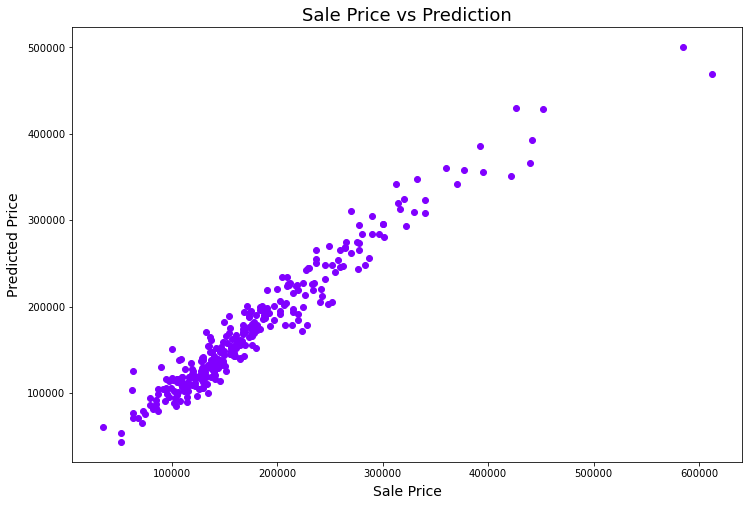

In [38]:
#Plotting the Sale price against the fitted price

fig = plt.figure(figsize=(12,8))
plt.scatter(y_test,preds,color=colors[0])
plt.title('Sale Price vs Prediction',fontsize = 18)
plt.xlabel('Sale Price', fontsize = 14, labelpad = 6)
plt.ylabel('Predicted Price', fontsize = 14, labelpad = 6)


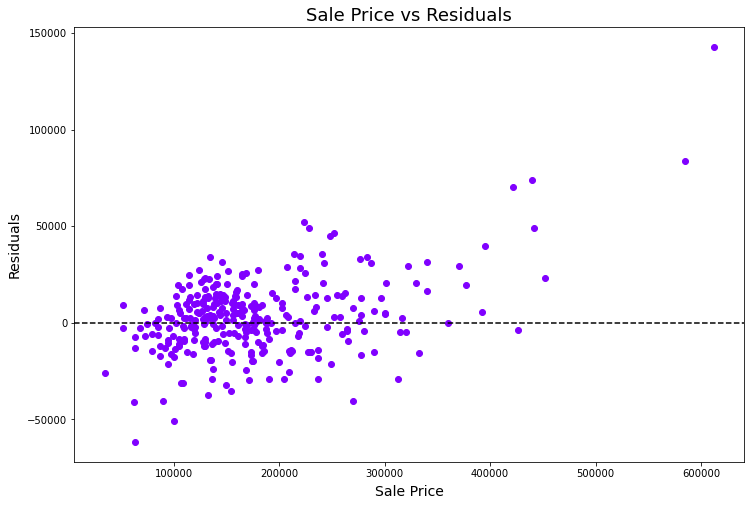

In [39]:
#Residuals vs sale price, there is still a bit of large price for the test set
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test,(y_test - preds),color=colors[0])
plt.title('Sale Price vs Residuals',fontsize = 18)
plt.xlabel('Sale Price', fontsize = 14, labelpad = 6)
plt.ylabel('Residuals', fontsize = 14, labelpad = 6)

plt.axhline(y= 0.0,color = 'black',linestyle = '--')



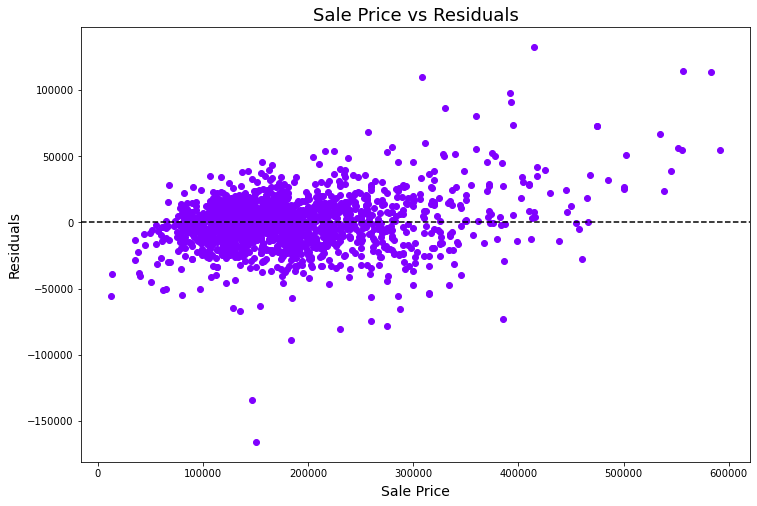

In [40]:
#Residuals vs sale price, there is still a bit of large price for the test set
train_preds = lr.predict(X_train)

fig = plt.figure(figsize=(12,8))
plt.scatter(y_train,(y_train - train_preds),color=colors[0])
plt.title('Sale Price vs Residuals',fontsize = 18)
plt.xlabel('Sale Price', fontsize = 14, labelpad = 6)
plt.ylabel('Residuals', fontsize = 14, labelpad = 6)

plt.axhline(y= 0.0,color = 'black',linestyle = '--')




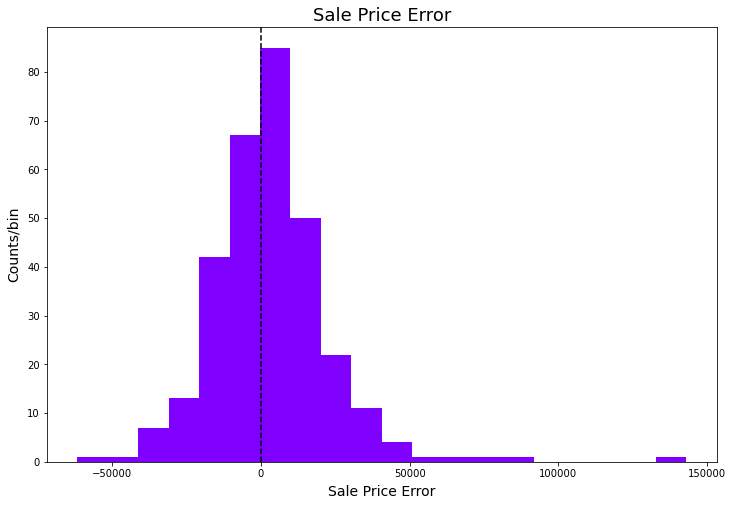

In [41]:
#Historgram of residuals
fig = plt.figure(figsize=(12,8))
plt.hist(y_test - preds,bins = 20,color=colors[0])
plt.title('Sale Price Error',fontsize = 18)
plt.xlabel('Sale Price Error', fontsize = 14, labelpad = 6)
plt.ylabel('Counts/bin', fontsize = 14, labelpad = 6)
plt.axvline(x= 0,color = 'black',linestyle = '--')


Text(0, 0.5, 'Sale Price')

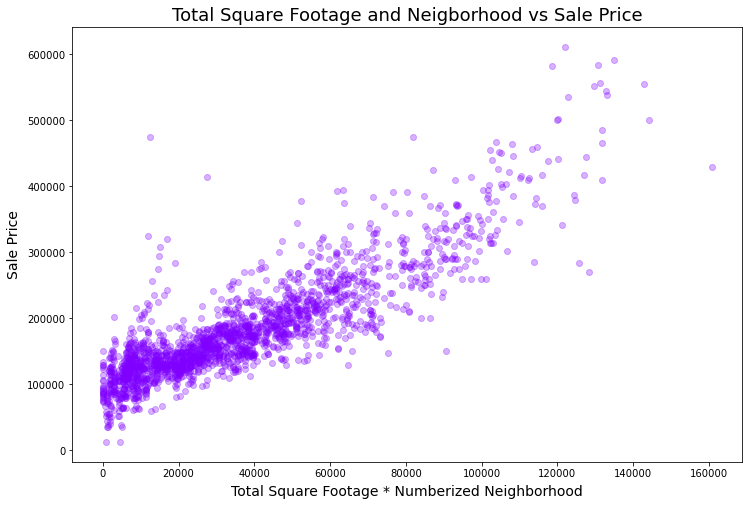

In [42]:
#Most powerful variable by itself. 
fig = plt.figure(figsize=(12,8))
plt.scatter(X['total_sf*neigh_num'],y,color=colors[0],alpha = 0.3)
plt.title('Total Square Footage and Neigborhood vs Sale Price',fontsize = 18)
plt.xlabel('Total Square Footage * Numberized Neighborhood', fontsize = 14, labelpad = 6)
plt.ylabel('Sale Price', fontsize = 14, labelpad = 6)


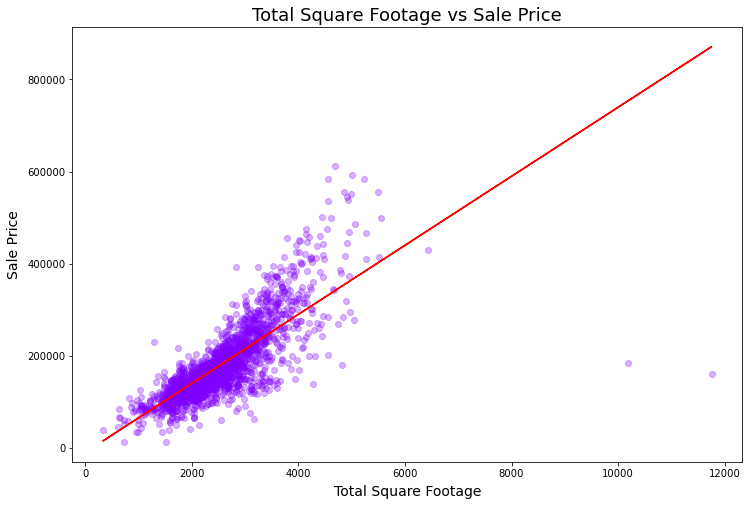

In [43]:
#Seperating SF from the above plot
X = house_high.drop(columns='SalePrice')
fig = plt.figure(figsize=(12,8))
plt.scatter(X['total_sf'],y,color=colors[0],alpha = 0.3)
plt.title('Total Square Footage vs Sale Price',fontsize = 18)
plt.xlabel('Total Square Footage', fontsize = 14, labelpad = 6)
plt.ylabel('Sale Price', fontsize = 14, labelpad = 6)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)
X_temp = X_train[['total_sf']]
y_temp = y_train
lr.fit(X_temp,y_temp)
plt.plot(X_temp, lr.coef_*X_temp + lr.intercept_,color='red')


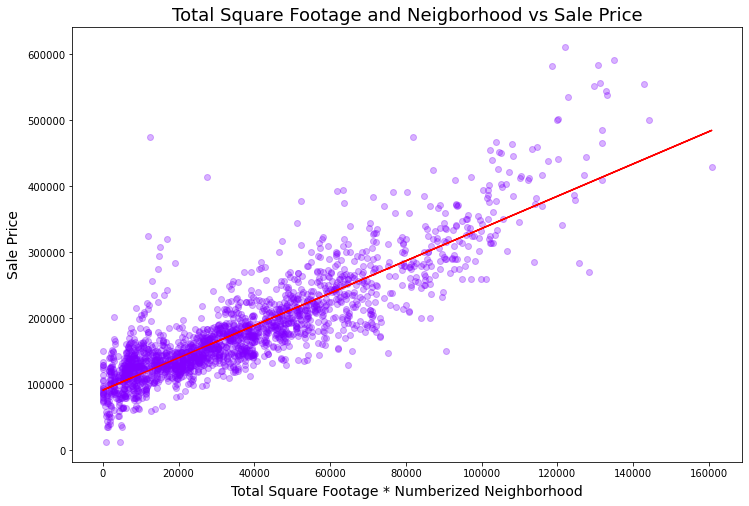

In [44]:
#Most powerful again with its fit. 

fig = plt.figure(figsize=(12,8))
plt.scatter(X['total_sf*neigh_num'],y,color=colors[0],alpha = 0.3)
plt.title('Total Square Footage and Neigborhood vs Sale Price',fontsize = 18)
plt.xlabel('Total Square Footage * Numberized Neighborhood', fontsize = 14, labelpad = 6)
plt.ylabel('Sale Price', fontsize = 14, labelpad = 6)

X_temp = X_train[['total_sf*neigh_num']]
y_temp = y_train
lr.fit(X_temp,y_temp)
plt.plot(X_temp, lr.coef_*X_temp + lr.intercept_,color='red')


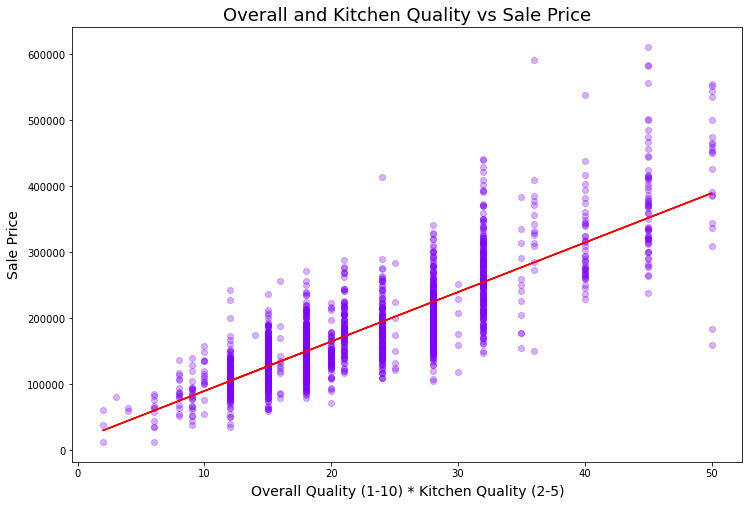

In [45]:
#The second variable (Using above as first) for fit iteration, strnog correlation

fig = plt.figure(figsize=(12,8))
plt.scatter(X['Overall Qual*Kitchen Qual'],y,color=colors[0],alpha = 0.3)
plt.title('Overall and Kitchen Quality vs Sale Price',fontsize = 18)
plt.xlabel('Overall Quality (1-10) * Kitchen Quality (2-5)', fontsize = 14, labelpad = 6)
plt.ylabel('Sale Price', fontsize = 14, labelpad = 6)

X_temp = X_train[['Overall Qual*Kitchen Qual']]
y_temp = y_train
lr.fit(X_temp,y_temp)
plt.plot(X_temp, lr.coef_*X_temp + lr.intercept_,color='red')


Text(0, 0.5, 'Sale Price')

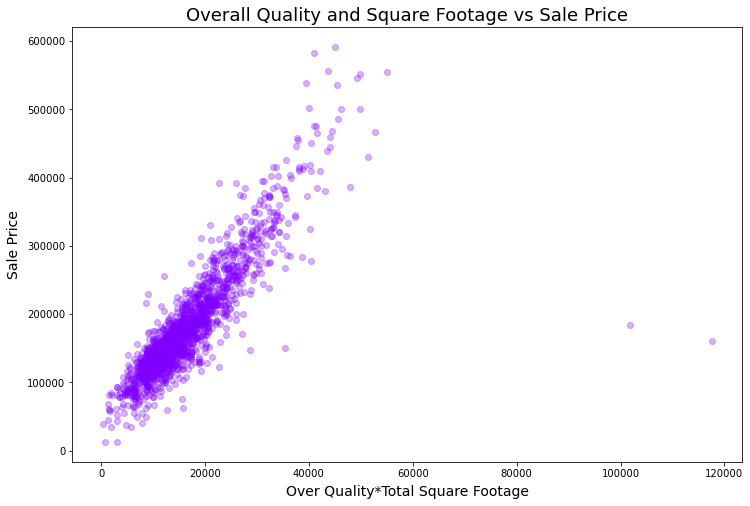

In [46]:
#This popped up before numerizing neighborhood and other things
#as the most powerful single feature
fig = plt.figure(figsize=(12,8))
plt.scatter(X_train['Overall Qual*total_sf'],y_train,color=colors[0],alpha = 0.3)
plt.title('Overall Quality and Square Footage vs Sale Price',fontsize = 18)
plt.xlabel('Over Quality*Total Square Footage', fontsize = 14, labelpad = 6)
plt.ylabel('Sale Price', fontsize = 14, labelpad = 6)




# Ouput for Kaggle submission
Perform the same data cleaning as for the train set of data

If something was not mapped from the training set of data, the category was set to be equivalent to the value for the mode. 

The following cleaning is in order as follows:
 - Fill most empties
 - Convert quality classification
 - See if any other garages were built 200 years in the future
 - Add intuitive variables
 - Dummify some columns
 - Drop PID (keep Id this time as needed for output
 - numberize categories
 
 At the end, I make sure the proper fit is used, make my predictions and save. 

In [47]:
#Read in Kaggle submission data
house_test_set = pd.read_csv('../datasets/test.csv')

In [48]:
#Same emptry filling from before
house_test_set['Lot Frontage'].fillna(house_test_set.groupby('Neighborhood')['Lot Frontage'].transform('mean'))
house_test_set['Lot Frontage'].fillna(house_test_set['Lot Frontage'].mean(),inplace=True)
house_test_set['Alley'].fillna('None',inplace=True)
house_test_set['Mas Vnr Type'].fillna('None',inplace=True)
house_test_set['Mas Vnr Area'].fillna(0,inplace=True)
house_test_set['Bsmt Qual'].fillna('None',inplace=True)
house_test_set['Bsmt Cond'].fillna('None',inplace=True)
house_test_set['Bsmt Exposure'].fillna('None',inplace=True)
house_test_set['BsmtFin Type 1'].fillna('None',inplace=True)
house_test_set['BsmtFin SF 1'].fillna(0,inplace=True)
house_test_set['BsmtFin Type 2'].fillna('None',inplace=True)
house_test_set['BsmtFin SF 2'].fillna(0,inplace=True)
house_test_set['Bsmt Unf SF'].fillna(0,inplace=True)
house_test_set['Total Bsmt SF'].fillna(0,inplace=True)
house_test_set['Bsmt Full Bath'].fillna(0,inplace=True)
house_test_set['Bsmt Half Bath'].fillna(0,inplace=True)
house_test_set['Fireplace Qu'].fillna('None',inplace=True)
house_test_set['Garage Type'].fillna('None',inplace=True)
house_test_set['Garage Yr Blt'].fillna(house_test_set['Garage Yr Blt'].mean(),inplace=True)
house_test_set['Garage Finish'].fillna('None',inplace=True)
house_test_set['Garage Cars'].fillna(0,inplace=True)
house_test_set['Garage Area'].fillna(0,inplace=True)
house_test_set['Garage Qual'].fillna('None',inplace=True)
house_test_set['Garage Cond'].fillna('None',inplace=True)
house_test_set['Pool QC'].fillna('None',inplace=True)
house_test_set['Fence'].fillna('None',inplace=True)
house_test_set['Misc Feature'].fillna('None',inplace=True)

In [49]:
#Numberize Qualtiy
house_test_set['Exter Qual'] = house_test_set['Exter Qual'].map(convert_qual)
house_test_set['Exter Cond'] = house_test_set['Exter Cond'].map(convert_qual)
house_test_set['Bsmt Qual'] = house_test_set['Bsmt Qual'].map(convert_qual)
house_test_set['Bsmt Cond'] = house_test_set['Bsmt Cond'].map(convert_qual)
house_test_set['Kitchen Qual'] = house_test_set['Kitchen Qual'].map(convert_qual)
house_test_set['Fireplace Qu'] = house_test_set['Fireplace Qu'].map(convert_qual)
house_test_set['Garage Qual'] = house_test_set['Garage Qual'].map(convert_qual)
house_test_set['Garage Cond'] = house_test_set['Garage Cond'].map(convert_qual)
house_test_set['Pool QC'] = house_test_set['Pool QC'].map(convert_qual)

In [50]:
#Look for future garages
house_test_set['Garage Yr Blt'] = house_test_set['Garage Yr Blt'].map(lambda x: np.nan if x > 2020 else x)
house_test_set['Garage Yr Blt'].fillna(house_test_set[house_test_set['Garage Yr Blt'].isnull()]['Year Remod/Add'].mean(),inplace=True)

In [51]:
#Make intuitive variables
house_test_set['total_sf'] = house_test_set['1st Flr SF'] + house_test_set['2nd Flr SF'] + house_test_set['Total Bsmt SF']
house_test_set['baths'] = house_test_set['Full Bath'] + house_test_set['Half Bath'] + house_test_set['Bsmt Full Bath'] + house_test_set['Bsmt Half Bath']
house_test_set['has_porch'] = (house_test_set['Open Porch SF'] + house_test_set['Enclosed Porch'] 
                      + house_test_set['3Ssn Porch'] + house_test_set['Screen Porch'] > 0).astype(int)
house_test_set['porch_sf'] = house_test_set['Open Porch SF'] + house_test_set['Enclosed Porch'] + house_test_set['3Ssn Porch'] + house_test_set['Screen Porch']
house_test_set['sold_after_0601'] = 12*(house_test_set['Yr Sold'] - 2006) + house_test_set['Mo Sold']
house_test_set['blt_after_1900'] = house_test_set['Year Built'] - 1900
house_test_set['rem_after_1900'] = house_test_set['Year Remod/Add'] - 1900
house_test_set['has_basement'] = (house_test_set['Total Bsmt SF'] > 0).astype(int)

In [52]:
#drop PID
house_test_set.drop(columns=['PID'],inplace=True)

In [53]:
#Map to same dictionary from earlier
house_test_set['neigh_num'] = house_test_set['Neighborhood'].map(dict_list[0])
house_test_set['ms_num'] = house_test_set['MS SubClass'].map(dict_list[1])
house_test_set['zone_num'] = house_test_set['MS Zoning'].map(dict_list[2])
house_test_set['lotshape_num'] = house_test_set['Lot Shape'].map(dict_list[3])
house_test_set['landcont_num'] = house_test_set['Land Contour'].map(dict_list[4])
house_test_set['util_num'] = house_test_set['Utilities'].map(dict_list[5])
house_test_set['lotconf_num'] = house_test_set['Lot Config'].map(dict_list[6])
house_test_set['slope_num'] = house_test_set['Land Slope'].map(dict_list[7])
house_test_set['neigh_num'] = house_test_set['Neighborhood'].map(dict_list[8])
house_test_set['cond1_num'] = house_test_set['Condition 1'].map(dict_list[9])
house_test_set['cond2_num'] = house_test_set['Condition 2'].map(dict_list[10])
house_test_set['bldgtyp_num'] = house_test_set['Bldg Type'].map(dict_list[11])
house_test_set['houstyle_num'] = house_test_set['House Style'].map(dict_list[12])
house_test_set['roofst_num'] = house_test_set['Roof Style'].map(dict_list[13])
house_test_set['roofmat_num'] = house_test_set['Roof Matl'].map(dict_list[14])
house_test_set['ext1_num'] = house_test_set['Exterior 1st'].map(dict_list[15])
house_test_set['ext2_num'] = house_test_set['Exterior 2nd'].map(dict_list[16])
house_test_set['masvnrtyp_num'] = house_test_set['Mas Vnr Type'].map(dict_list[17])
house_test_set['found_num'] = house_test_set['Foundation'].map(dict_list[18])
house_test_set['bsmtexp_num'] = house_test_set['Bsmt Exposure'].map(dict_list[19])
house_test_set['bsmtexp_num'] = house_test_set['Bsmt Exposure'].map(dict_list[20])
house_test_set['bsmtfin1_num'] = house_test_set['BsmtFin Type 1'].map(dict_list[21])
house_test_set['bsmtfin2_num'] = house_test_set['BsmtFin Type 2'].map(dict_list[22])
house_test_set['heat_num'] = house_test_set['Heating'].map(dict_list[23])
house_test_set['elec_num'] = house_test_set['Electrical'].map(dict_list[24])
house_test_set['gartyp_num'] = house_test_set['Garage Type'].map(dict_list[25])
house_test_set['fence_num'] = house_test_set['Fence'].map(dict_list[26])
house_test_set['garfin_num'] = house_test_set['Garage Finish'].map(dict_list[27])
house_test_set['func_num'] = house_test_set['Functional'].map(dict_list[28])
house_test_set['misc_num'] = house_test_set['Misc Feature'].map(dict_list[29])
house_test_set['sale_num'] = house_test_set['Sale Type'].map(dict_list[30])

In [54]:
#Dummify categories with 2-3 uniques
house_test_set = pd.get_dummies(house_test_set,columns=['Street'],drop_first=True)
house_test_set = pd.get_dummies(house_test_set,columns=['Central Air'],drop_first=True)
house_test_set = pd.get_dummies(house_test_set,columns=['Paved Drive'],drop_first=True)

In [55]:
#Fill new stuff with mode value
house_test_set['roofmat_num'].fillna(house_test_set['roofmat_num'].mode()[0],inplace=True)
house_test_set['ext1_num'].fillna(house_test_set['ext1_num'].mode()[0],inplace=True)
house_test_set['ext2_num'].fillna(house_test_set['ext2_num'].mode()[0],inplace=True)
house_test_set['masvnrtyp_num'].fillna(house_test_set['masvnrtyp_num'].mode()[0],inplace=True)
house_test_set['heat_num'].fillna(house_test_set['heat_num'].mode()[0],inplace=True)
house_test_set['sale_num'].fillna(house_test_set['sale_num'].mode()[0],inplace=True)
#Mode value
house_test_set['Electrical'].fillna('SBrkr',inplace=True)

In [56]:
#Add interaction terms
new_num = number_cols[:]
new_num.remove('SalePrice')
house_test_high = house_test_set[new_num]
print(house_test_set.shape, house_high.shape)
for i in range(len(new_num)):
    col = new_num[i]
    if col in cols_to_skip:
        pass
    else:
        for j in range(i,len(new_num)):
            col2 = new_num[j]
            if col2 in cols_to_skip:
                pass
            else:
                house_test_high[col+'*'+col2] = house_test_set[col]*house_test_set[col2]
house_test_high['Id'] = house_test_set['Id']
house_test_high.shape

(878, 117) (2051, 1857)


<ipython-input-56-fbb16e47cb31>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_test_high[col+'*'+col2] = house_test_set[col]*house_test_set[col2]


(878, 1857)

In [57]:
#Make sure fit is current on most reacet training set
cat_mse = ['total_sf*neigh_num','Overall Qual*Kitchen Qual','neigh_num*neigh_num','Bsmt Unf SF*blt_after_1900',
  'Garage Cars*sale_num','Overall Cond*total_sf','Total Bsmt SF*total_sf','Overall Cond*neigh_num',
  'blt_after_1900*bsmtexp_num','Lot Area*ext1_num','Overall Qual*Exter Qual','blt_after_1900*cond1_num',
  'landcont_num*roofst_num','Garage Area*porch_sf','MS SubClass','Fireplace Qu',
  'has_porch*neigh_num','has_basement*neigh_num','Bsmt Qual*zone_num','total_sf*bsmtfin2_num',
  'Lot Area*Lot Area','neigh_num*sale_num','sale_num*sale_num','has_porch*rem_after_1900',
  'houstyle_num*ext2_num','heat_num*func_num','porch_sf*misc_num','Screen Porch',
  'Bsmt Qual*Garage Cars','Lot Frontage*Paved Drive_Y','Bsmt Unf SF*porch_sf','Bsmt Qual*bsmtfin2_num',
  'total_sf*zone_num','baths*rem_after_1900','Bedroom AbvGr*neigh_num','Bedroom AbvGr*zone_num',
  'Overall Qual*total_sf','Overall Qual','Year Remod/Add*Kitchen Qual','Fireplaces']
X = house_high[cat_mse]
#New predictions for test set
X_new = house_test_high[cat_mse]
y = house_high['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.15,random_state = 9)
lr.fit(X_train,y_train)

LinearRegression()

In [58]:
#Predict new values and output
preds = lr.predict(X_new)
kaggle_output = {'Id':house_test_high['Id'], 'SalePrice':preds}
kaggle_output = pd.DataFrame(kaggle_output)
kaggle_output.to_csv('../data_out/sub_1.csv', index = False)